In [1]:
import tensorflow as tf
import numpy as np
import zipfile36 as zipfile
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from shutil import copyfile
import os


In [2]:
# Extract the Zipfile :


In [3]:
folder_download_zip_dir = "./kagglecatsanddogs_5340.zip"

In [4]:
extract_zip = zipfile.ZipFile(folder_download_zip_dir,'r')

In [5]:
store_dir = './temp/'

In [6]:
extract_zip.extractall(store_dir)
extract_zip.close()

In [7]:
# Check number of dogs & Cats Images in extracted folder :

In [8]:
print("Number of Dogs Images : ", len(os.listdir('./temp/PetImages/Dog/')))
print("Number of cats Images : ", len(os.listdir('./temp/PetImages/Cat/')))

Number of Dogs Images :  12501
Number of cats Images :  12501


In [9]:
# Create training & Testing sub-folder. Each Traing & Testing Folder will contain Dog & Cat sub-foder :

In [10]:
try:
    os.makedirs("./temp/cats_vs_dogs")
    os.makedirs("./temp/cats_vs_dogs/training")
    os.makedirs("./temp/cats_vs_dogs/training/dog")
    os.makedirs("./temp/cats_vs_dogs/training/cat")
    
    os.makedirs("./temp/cats_vs_dogs/testing")
    os.makedirs("./temp/cats_vs_dogs/testing/dog")
    os.makedirs("./temp/cats_vs_dogs/testing/cat")
except OSError(e):
    print(e)

In [11]:
# Split the data into training & test sets :
#   1. First check whether the image file is empty, ignore that file :
#   2. Second those image files not empty keep 90% of data in training set & 10% in testing set :

In [12]:
import random

In [13]:
def split_data(SOURCE,TRAINING,TESTING,SPLIT_SIZE):
    
    # Store image containing data in files list to split data into trining and testing folder :   
    
    files = []
    for image in os.listdir(SOURCE):
        file = os.path.join(SOURCE,image)
        if os.path.getsize(file) > 0:
            files.append(image)
        else:
            print(f"{image} is zero length, so ignoring.\n")
            
    # Calculates the  training size & testing size :
    training_size = int(len(files) * SPLIT_SIZE)
    testing_size =  int(len(files) - training_size)
    
    traning_set_final = files[0:training_size]
    testing_set_final = files[0:testing_size]
    
    # Copy image from source to destination folder  : Traning image :
    for image in traning_set_final :
        this_file = os.path.join(SOURCE,image)
        destination_file = os.path.join(TRAINING,image)
        copyfile(this_file,destination_file)
        
    # Copy image from Souce to destination folder : Testing image :
    for image in testing_set_final :
        this_file = os.path.join(SOURCE,image)
        destination_file = os.path.join(TESTING,image)
        copyfile(this_file,destination_file)
        
    

CAT_SOURCE_DIR = "/DATA/16_My_Project/Tensorflow/temp/PetImages/Cat/"

TRAINING_CATS_DIR = "/DATA/16_My_Project/Tensorflow/temp/cats_vs_dogs/training/cat/"
TESTING_CATS_DIR = "/DATA/16_My_Project/Tensorflow/temp/cats_vs_dogs/testing/cat/"
DOG_SOURCE_DIR = "/DATA/16_My_Project/Tensorflow/temp/PetImages/Dog/"
TESTING_DOGS_DIR = "/DATA/16_My_Project/Tensorflow/temp/cats_vs_dogs/testing/dog/"
TRAINING_DOGS_DIR = "/DATA/16_My_Project/Tensorflow/temp/cats_vs_dogs/training/dog/"


split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.

11702.jpg is zero length, so ignoring.



In [14]:
# Applying Data Agumentation :

In [15]:
training_dir = "./temp/cats_vs_dogs/training/"

In [19]:
testing_dir = "./temp/cats_vs_dogs/testing/"

In [16]:
training_datagen = ImageDataGenerator(rescale=1./255.,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

In [17]:
training_data = training_datagen.flow_from_directory(directory=training_dir,target_size=(150,150),batch_size=100,class_mode='binary')

Found 22500 images belonging to 2 classes.


In [18]:
testing_datagen = ImageDataGenerator(rescale=1./255.)

In [20]:
testing_data = testing_datagen.flow_from_directory(directory=testing_dir,target_size=(150,150),batch_size=100,class_mode='binary')

Found 2500 images belonging to 2 classes.


In [21]:
# get & Prepare the model : Inception model 

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [23]:
pre_defined_weight = "./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [26]:
# Instantiate the model : Donot use New weight & use only predefined optimized weights :

In [27]:
pre_defined_model = InceptionV3(input_shape=(150,150,3),include_top=False,weights=None)


In [28]:
# Load the pre-trained weights :

In [29]:
pre_defined_model.load_weights(pre_defined_weight)

In [30]:
# Freeze the layer of pre-trained model :

In [31]:
for layer in pre_defined_model.layers:
    layer.trainable = False

In [32]:
# Print out the Summery of the model's layer :

In [33]:
pre_defined_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [34]:
# Grap the last layer from model :

In [35]:
last_layer = pre_defined_model.get_layer("mixed7")


In [36]:
print("Last layer out-put shape :",last_layer.output_shape)

last_output = last_layer.output

Last layer out-put shape : (None, 7, 7, 768)


In [39]:
# Flatten the output layer to 1-D :

In [40]:
x = layers.Flatten()(last_output)

In [43]:
# add fully-connected layer with 1024 hidden units & Relu Activation :

In [44]:
x = layers.Dense(units=1024,activation='relu')(x)

In [45]:
# Add a final Sigmoid layer for classification :

In [46]:
x = layers.Dense(units=1, activation='sigmoid')(x)

In [48]:
# Add to input and output layers to your custom model :
from tensorflow.keras import Model

In [49]:
model = Model(pre_defined_model.input,x)

In [50]:
# Train the model :

In [51]:
   # 1. Compile the model :

In [52]:
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

In [290]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [53]:
history = model.fit(training_data,validation_data=testing_data,epochs=2,verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 25 steps
Epoch 1/2
225/225 [==============================] - 388s 2s/step - loss: 0.3349 - accuracy: 0.8613 - val_loss: 0.2075 - val_accuracy: 0.9476
Epoch 2/2
225/225 [==============================] - 194s 864ms/step - loss: 0.2500 - accuracy: 0.8907 - val_loss: 0.1376 - val_accuracy: 0.9584


In [55]:
history.history

{'loss': [0.3348715612623427, 0.2500246783097585],
 'accuracy': [0.8612889, 0.89066666],
 'val_loss': [0.20746990233659746, 0.1375586773455143],
 'val_accuracy': [0.9476, 0.9584]}

In [56]:
# print the metrices :

In [57]:
acc = history.history['accuracy']

In [58]:
acc

[0.8612889, 0.89066666]

In [59]:
loss = history.history['loss']

In [60]:
loss

[0.3348715612623427, 0.2500246783097585]

In [61]:
val_acc = history.history['val_accuracy']

In [62]:
val_acc

[0.9476, 0.9584]

In [64]:
val_loss = history.history['val_loss']

In [65]:
val_loss

[0.20746990233659746, 0.1375586773455143]

In [66]:
# Get total number of epoch :

In [76]:
epoches = range(len(acc))

In [77]:
epoches

range(0, 2)

In [78]:
# Plot the training and Validation accuracy per epoches :

In [79]:
from matplotlib import pyplot as plt
%matplotlib inline

<Figure size 432x288 with 0 Axes>

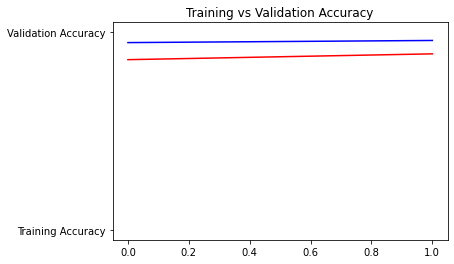

<Figure size 432x288 with 0 Axes>

In [82]:
plt.plot(epoches,acc,'r','Training Accuracy')
plt.plot(epoches,val_acc,'b','Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.figure()

In [228]:
# Testing your model accuracy with an unknown image of Dogs or Cats 

In [229]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [275]:
image = "7_image.jpg"


In [276]:
path = "./temp/Content/"

In [277]:
image_dir = os.path.join(path,image)

In [278]:
img = load_img(image_dir,target_size=(150,150))

In [279]:
image_to_array = img_to_array(img)

In [280]:
image_to_array /= 255

In [281]:
# expand dimension of the image : along row direction

In [282]:
image_to_array_expand = np.expand_dims(image_to_array,axis=0)

In [283]:
image_tensor = np.vstack([image_to_array_expand])

In [284]:
classes = model.predict(image_tensor)

In [285]:
classes

array([[0.9946075]], dtype=float32)

In [286]:
if classes[0] > 0.5 :
    print(f"{image} is a Dog.\n")
else :
    print(f"{image} is a Cat.\n")

7_image.jpg is a Dog.



In [287]:
import matplotlib.image as img 

In [288]:
read_img = img.imread(image_dir)

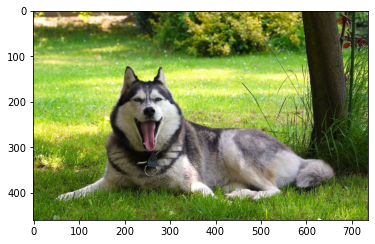

In [289]:
plt.imshow(read_img)